# Unit Commitment (UC)
This notebook is inspired by Chapter 5 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.<br><br>

The data used in this chapter is inspired by the following paper as well as the above book chapter:<br>
Ademovic A, Bisanovic S, Hajro M. A genetic algorithm solution to the unit commitment problem based on real-coded chromosomes and fuzzy optimization. InMelecon 2010-2010 15th IEEE Mediterranean Electrotechnical Conference 2010 Apr 26 (pp. 1476-1481). IEEE.<br><br>

**The problem:** <br>
The unit commitment problem or reactive energy generation scheduling entails coordinating the deployment of energy sources (e.g. generators) to meet demand, while achieving a common goal. The common goal could be to minimize the total cost of generation, or to maximize the total revenue. Unit commitment is NP-hard, and is a mixed integer problem. <br><br>
**Difference between UC and DED:** <br>
Through the unit commitment problem, we determine which geneartors to turn on and which ones to shut down to meet the demand. Once the generators are chosen, we run the DED process to determine how much power each geneartor should produce.

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Cost-based Unit Commitment
In a UC problem, we want to minimize the total cost of power generation. For gas generators, there are 3 categories of cost to be considered, which include fuel costs $(FC)$, start up costs $(Su)$, and shut down costs $(Sd)$. So the total cost can be formulated as [2]:
$$
\underset{p,u,y,z} {min} \ \ \ \ TC = \sum_{g,t}^{} FC_{g,t} + Su_{g} y_{g,t} + Sd_{g} z_{g,t}
$$
where $Su_{g}$ is a function of turbine startup cost, boiler startup cost, and the unit's cooling speed. For simplicity, we assume that both $Su_{g}$ and $Sd_{g}$ are constant in this problem [1]. <br>
We introduce three binary variables to track the state of each generator [1]:
$$u_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; on\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$
$$y_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; generator \; were \; to \; start \; up \; at \; time \; t\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$
$$z_{g,t} =\begin{equation}
\left\{ 
  \begin{aligned}
    1 \; & \; if \; generator \; were \; to \; shut \; down \; at \; time \; t\\
    0 \; & \; otherwise\\
  \end{aligned}
  \right.
\end{equation}
$$<br>
Each unit can be in either startup or shutdown mode at any given time [1]:
$$
y_{g,t} + z_{g,t} \le 1
$$
And the following elationship exists among $u_{g,t}$, $y_{g,t}$, and $z_{g,t}$ [1]:
$$
y_{g,t} - z_{g,t} = u_{g,t} - u_{g,t-1}
$$



# Fuel cost
Similar to the approach used in DED, a quadratic function for fuel cost can be linearized as follows [1]:
$$
0 \le P_{g,t}^{k} \le \Delta P_{g}^{k} u_{g,t}, \; \forall k=1:n
$$

$$
\Delta P_{g}^{k} = \frac {P_{g}^{max} - P_{g}^{min}} {n}
$$

$$
P_{g,begin}^{k} = (k-1)\Delta P_{g}^{k} + P_{g}^{min}
$$

$$
P_{g,end}^{k} = P_{g,begin}^{k} + \Delta P_{g}^{k}
$$
$$
Ptot_{g,t} = P_{g}^{min} u_{g,t} + \sum_{k}^{} P_{g,t}^{k}
$$
$$
C_{g,begin}^{k} = c_{g} {(P_{g,begin}^{k})}^2 + b_{g} P_{g,begin}^{k} + a_{g}
$$
$$
C_{g,end}^{k} = c_{g} {(P_{g,end}^{k})}^2 + b_{g} P_{g,end}^{k} + a_{g}
$$

$$
s_{g}^{k} = \frac{C_{g,end}^{k} - C_{g,begin}^{k}}{\Delta P_{g}^{k}}
$$

$$
FC_{g,t} = (c_{g} {(P_{g}^{min})}^{2} + b_{g} P_{g}^{min} + a_{g}) u_{g,t} + \sum_{k}^{} s_{g}^{k} P_{g,t}^{k}
$$

# Ramp up/down
Changes in power generation from thermal generators are limited to how fast the units can ramp up their geneartion or ramp it down. In the case of shutting down, or starting up a unit, we also need to take into account shut-down $(SDR)$ or start-up $(SUR)$ ramp limits. A more comprehensive description of these constraints can be found in [1].
$$
\underline{P}_{g,t} \le Ptot_{g,t} \le \overline{P}_{g,t}
$$
$$
\overline{P}_{g,t} \le P_{g}^{max}[u_{g,t} - z_{g,t+1}] + SDR_{g}z_{g,t+1}
$$
$$
\overline{P}_{g,t} \le P_{g,t-1} + RU_{g}u_{g,t-1} + SUR_{g}y_{g,t}
$$
$$
\underline{P}_{g,t} \ge P_{g,t}^{min}u_{g,t}
$$
$$
\underline{P}_{g,t} \ge P_{g,t-1} - RD_{g}u_{g,t} - SDR_{g}z_{g,t}
$$

# Uptime and Downtime
Thermal generators have minimum uptime and downtime requirements. If thermal generator $g$ starts up, it needs to run for at least $T_{g}^{on}$, and if it shuts down it needs to be off for at least $T_{g}^{on}$. The linearized uptime and downtime constraints are  presented below [1,3]:<br>
**Uptime Constraints**
$$
\sum_{t=1}^{\zeta_{g}} (1-u_{g,t}) = 0
$$
$$
\sum_{t=k}^{k+T_{g}^{on}-1} u_{g,t} \ge T_{g}^{on} y_{g,t} \;\;\; \forall k = \zeta_{g}+1 ... T-T_{g}^{on}+1
$$
$$
\sum_{t=k}^{T} (u_{g,t}-y_{g,t}) \ge 0 \;\;\; \forall k = T-T_{g}^{on}+2 ... T
$$
$$
\zeta_{g} = min \left\{ T , (T_{g}^{on}-U_{g}^{0})u_{g,t=0} \right\}
$$
where $U_{g}^{0}$ is the number of hours unit $g$ has been in startup mode at the start of the UC time horizon, and $u_{g,t=0}$ is the operating state of unit $g$ at the start of the UC time horizon [1,3].<br>
**Downtime Constraints**
$$
\sum_{t=1}^{\xi_{g}} (1-u_{g,t}) = 0
$$
$$
\sum_{t=k}^{k+T_{g}^{off}-1} (1-u_{g,t}) \ge T_{g}^{off} z_{g,t} \;\;\; \forall k = \xi_{g}+1 ... T-T_{g}^{off}+1
$$
$$
\sum_{t=k}^{T} (1-u_{g,t}-z_{g,t}) \ge 0 \;\;\; \forall k = T-T_{g}^{off}+2 ... T
$$
$$
\xi_{g} = min \left\{ T , (T_{g}^{off}-S_{g}^{0})[1-u_{g,t=0}] \right\}
$$
where $S_{g}^{0}$ is the number of hours unit $g$ has been in shutdown mode at the start of the UC time horizon, and $u_{g,t=0}$ is the operating state of unit $g$ at the start of the UC time horizon.<br>

And finally for demand-generation balance we have the following constraint:
$$
\sum_{g}^{} Ptot_{g,t} \ge L_{t}
$$
The parameters for this UC problem are summarized in the table below [2]:

In [2]:
UC_df = pd.DataFrame()
UC_df["Unit"] = ["g1", "g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9", "g10"]
UC_df["$a_{g}$"] = [82, 49, 100, 105, 72, 29, 32, 40, 25, 15]
UC_df["$b_{g}$"] = [12.1, 12.6, 13.2, 13.9, 13.5, 15.4, 14, 13.5, 15, 14.3]
UC_df["$c_{g}$"] = [0.0148, 0.0289, 0.0135, 0.0127, 0.0261, 0.0212, 0.0382, 0.0393, 0.0396, 0.0510]
UC_df["$Sd_{g}$"] = [42.5, 50.5, 57., 47., 56.5, 141., 113.5, 42.5, 50.5, 57.]
UC_df["$Su_{g}$"] = [42.5, 50.5, 57., 47., 56.5, 141., 113.5, 42.5, 50.5, 57.]
UC_df["$RU_{g}$"] = [40, 64, 30, 104, 56, 30, 24, 22, 16, 12]
UC_df["$RD_{g}$"] = [40, 64, 30, 104, 56, 30, 24, 22, 16, 12]
UC_df["$T_{g}^{on}$"] = [3, 4, 3, 5, 4, 3, 3, 3, 0, 0]
UC_df["$T_{g}^{off}$"] = [2, 2, 2, 3, 2, 2, 2, 2, 0, 0]
UC_df["$SDR_{g}$"] = [90, 130, 70, 240, 110, 60, 50, 45, 35, 30]
UC_df["$SUR_{g}$"] = [110, 140, 80, 250, 130, 80, 60, 55, 45, 40]
UC_df["$P_{min}$"] = [80, 120, 50, 250, 80, 50, 30, 30, 20, 20]
UC_df["$P_{max}$"] = [200, 320, 150, 520, 280, 150, 120, 110, 80, 60]
UC_df["$U_{g}^{0}$"] = [1, 2, 3, 1, 1, 0, 0, 0, 0, 0]
UC_df["$u_{g,t0}$"] = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
UC_df["$S_{g}^{0}$"] = [1, 0, 2, 0, 0, 0, 0, 0, 0, 0]

UC_df.head()

,Unit,$a_{g}$,$b_{g}$,$c_{g}$,$Sd_{g}$,$Su_{g}$,$RU_{g}$,$RD_{g}$,$T_{g}^{on}$,$T_{g}^{off}$,$SDR_{g}$,$SUR_{g}$,$P_{min}$,$P_{max}$,$U_{g}^{0}$,"$u_{g,t0}$",$S_{g}^{0}$
0,g1,82,12.1,0.0148,42.5,42.5,40,40,3,2,90,110,80,200,1,0,1
1,g2,49,12.6,0.0289,50.5,50.5,64,64,4,2,130,140,120,320,2,0,0
2,g3,100,13.2,0.0135,57.0,57.0,30,30,3,2,70,80,50,150,3,0,2
3,g4,105,13.9,0.0127,47.0,47.0,104,104,5,3,240,250,250,520,1,1,0
4,g5,72,13.5,0.0261,56.5,56.5,56,56,4,2,110,130,80,280,1,1,0


In [3]:
demands = [883, 915, 1010, 1149, 1236, 1331, 1397, 1419, 1455, 1455, 1441, 1419, 1397, 1339, 1368, 1339, 1236,\
           1105, 1038, 959, 922, 885, 915, 834]
lambdas = [14.72, 15.62, 15.62, 15.62, 15, 16, 20, 23.5, 24, 21, 20, 17, 18, 17.5, 18.8, 17.5, 23.5, \
                     18.8, 18.9, 18.9, 20.9, 20.9, 20.5, 15.62]

In [4]:
model = ConcreteModel()

#Indices
model.g = RangeSet(len(UC_df))                            #Number of generators
model.t = RangeSet(24)                                    #UC time horizon in hours
model.k = RangeSet(20)                                    #Nmber of sub-intervals for linearizing the cost function

#Parameters
model.T = Param(initialize=len(model.t), within=NonNegativeIntegers)         #End of UC time horizon
model.gmma = Param(initialize=0.4, within=NonNegativeReals)                  #Percentage of load to be met by spinning reserve
model.cmin = Param(initialize=0.1, within=NonNegativeReals, mutable=True)    #Lower bound parameter for demand response
model.cmax = Param(initialize=0.1, within=NonNegativeReals, mutable=True)    #Upper bound parameter for demand response

def cost_a(model, g):
    return UC_df.loc[g-1,"$a_{g}$"]
model.a = Param(model.g, initialize=cost_a, within=Reals)                    #Gas generator cost coefficient

def cost_b(model, g):
    return UC_df.loc[g-1,"$b_{g}$"]
model.b = Param(model.g, initialize=cost_b, within=Reals)                    #Gas generator cost coefficient                

def cost_c(model, g):
    return UC_df.loc[g-1,"$c_{g}$"]
model.c = Param(model.g, initialize=cost_c, within=Reals)                    #Gas generator cost coefficient

def cost_Sd(model, g):
    return UC_df.loc[g-1,"$Sd_{g}$"]
model.Sd = Param(model.g, initialize=cost_Sd, within=Reals)                  #Gas generator shutdown cost

def cost_Su(model, g):
    return UC_df.loc[g-1,"$Su_{g}$"]
model.Su = Param(model.g, initialize=cost_Su, within=Reals)                  #Gas generator startup cost

def P_min_df(model, g):
    return UC_df.loc[g-1,"$P_{min}$"]
model.P_min = Param(model.g, initialize=P_min_df, within=Reals)              #Gas generator power lower bound

def P_max_df(model, g):
    return UC_df.loc[g-1,"$P_{max}$"]
model.P_max = Param(model.g, initialize=P_max_df, within=Reals)              #Gas generator power upper bound

def ramp_up(model, g):
    return UC_df.loc[g-1,"$RU_{g}$"]
model.RU = Param(model.g, initialize=ramp_up, within=Reals)                  #Gas generator ramp-up rate

def ramp_down(model, g):
    return UC_df.loc[g-1,"$RD_{g}$"]
model.RD = Param(model.g, initialize=ramp_down, within=Reals)                #Gas generator ramp-down rate

def min_uptime(model, g):
    return UC_df.loc[g-1,"$T_{g}^{on}$"]
model.Ton = Param(model.g, initialize=min_uptime, within=Reals)              #Minimum uptime of generator

def min_downtime(model, g):
    return UC_df.loc[g-1,"$T_{g}^{off}$"]
model.Toff = Param(model.g, initialize=min_downtime, within=Reals)           #Minimum downtime of generator

def startup_ramp(model, g):
    return UC_df.loc[g-1,"$SUR_{g}$"]
model.SUR = Param(model.g, initialize=startup_ramp, within=Reals)            #Gas generator startup ramp rate

def shutdown_ramp(model, g):
    return UC_df.loc[g-1,"$SDR_{g}$"]
model.SDR = Param(model.g, initialize=shutdown_ramp, within=Reals)           #Gas generator shutdown ramp rate

def initial_uptime(model, g):
    return UC_df.loc[g-1,"$U_{g}^{0}$"]
model.U0 = Param(model.g, initialize=initial_uptime, within=Reals)           #Initial uptime of generator

def initial_state(model, g):
    return UC_df.loc[g-1,"$u_{g,t0}$"]
model.u0 = Param(model.g, initialize=initial_state, within=Reals)           #Initial state of generator

def initial_downtime(model, g):
    return UC_df.loc[g-1,"$S_{g}^{0}$"]
model.S0 = Param(model.g, initialize=initial_downtime, within=Reals)        #Initial downtime of generator

def delta_p(model, g):
    return (model.P_max[g] - model.P_min[g]) / len(model.k)
model.deltap = Param(model.g, initialize=delta_p, within=NonNegativeReals)  #Power linearization increments

def p_begin(model, g, k):
    return (k-1) * model.deltap[g] + model.P_min[g]
model.Pbegin = Param(model.g, model.k, initialize=p_begin, within=NonNegativeReals)      #Beginning of the linearized power interval

def p_end(model, g, k):
    return model.Pbegin[g,k] + model.deltap[g]
model.Pend = Param(model.g, model.k, initialize=p_end, within=NonNegativeReals)          #End of the linearized power interval

def C_begin(model, g, k):
    return model.c[g]*model.Pbegin[g,k]**2 + model.b[g]*model.Pbegin[g,k] + model.a[g]
model.Cbegin = Param(model.g, model.k, initialize=C_begin, within=NonNegativeReals)      #Beginning of the linearized cost interval

def C_end(model, g, k):
    return model.c[g]*model.Pend[g,k]**2 + model.b[g]*model.Pend[g,k] + model.a[g]
model.Cend = Param(model.g, model.k, initialize=C_end, within=NonNegativeReals)          #End of the linearized cost interval

def cost_gradient(model, g, k):
    return (model.Cend[g,k] - model.Cbegin[g,k]) / model.deltap[g]
model.s = Param(model.g, model.k, initialize=cost_gradient, within=NonNegativeReals)    #Slope of the linearized cost interval

def demand(model, t):
    return demands[t-1]
model.L = Param(model.t, initialize=demand, within=Reals, mutable=True)      #Forecasted demand in the optimization horizon

def prices(model, t):
    return lambdas[t-1]
model.lmbd = Param(model.t, initialize=prices, within=Reals, mutable=True)   #Forecasted energy price in the optimization horizon

def zeta_limit(model, g):
    return int(min(model.T , (model.Ton[g] - model.U0[g]) * model.u0[g]))
model.zeta = Param(model.g, initialize=zeta_limit, within=NonNegativeReals)  #Hours to remain in startup mode at the beginning

def xi_limit(model, g):
    return int(min(model.T , (model.Toff[g] - model.S0[g]) * (1-model.u0[g])))
model.xi = Param(model.g, initialize=xi_limit, within=NonNegativeReals)      #Hours to remain in shutdown mode at the beginning

#Variables
model.P = Var(model.g, model.t, model.k, within=NonNegativeReals)            #Linearized power output of the generator
model.P_ = Var(model.g, model.t, within=NonNegativeReals)                    #Lower operating limit
model.Pup = Var(model.g, model.t, within=NonNegativeReals)                   #Upper operating limit
model.u = Var(model.g, model.t, within=Binary)                               #Binary variable denoting whether the unit is on/off
model.y = Var(model.g, model.t, within=Binary)                               #Binary variable denoting whether the unit is in startup mode
model.z = Var(model.g, model.t, within=Binary)                               #Binary variable denoting whether the unit is in shutdown mode
model.SR = Var(model.g, model.t, within=NonNegativeReals)                    #Spinning Reserve capacity
model.D = Var(model.t, within=NonNegativeReals)                              #Demand Response

#Expressions
def Pg_generation(model, g, t):
    return  model.P_min[g]*model.u[g,t] + sum(model.P[g,t,k] for k in model.k)
model.Ptot = Expression(model.g, model.t, rule=Pg_generation)                #Power output from the generator

def generator_fuel_cost(model, g, t):
    return (model.c[g]*model.P_min[g]**2 + model.b[g]*model.P_min[g] + model.a[g]) * model.u[g,t] + \
            sum(model.P[g,t,k]*model.s[g,k] for k in model.k)
model.FC = Expression(model.g, model.t, rule=generator_fuel_cost)            #Gas generator fuel cost

def startup_cost(model, g, t):
    return  model.Su[g] * model.y[g,t]
model.SUC = Expression(model.g, model.t, rule=startup_cost)                  #Gas generator startup cost

def shutdown_cost(model, g, t):
    return  model.Sd[g] * model.z[g,t]
model.SDC = Expression(model.g, model.t, rule=shutdown_cost)                 #Gas generator shutdown cost

#Constraints
def uyz_constraint(model, g, t):
    if t==1:
        return Constraint.Skip
    else:
        return  (model.y[g,t] - model.z[g,t]) == (model.u[g,t] - model.u[g,t-1])
model.c_uyz = Constraint(model.g, model.t, rule=uyz_constraint)             #Constraint between binary variables

def startup_or_shutdown_constraint(model, g, t):
    return  (model.y[g,t] + model.z[g,t]) <= 1
model.c_su_or_sd = Constraint(model.g, model.t, rule=startup_or_shutdown_constraint)     #Startup/shutdown either/or constraint

def generation_delta_limit(model, g, t, k):
    return  model.P[g,t,k] <= model.deltap[g] * model.u[g,t]
model.c_generation_delta_limit = Constraint(model.g, model.t, model.k, rule=generation_delta_limit)   #Linearized power increment constraint

def generation_lower_bound(model, g, t):
    return  model.Ptot[g,t] >= model.P_[g,t]
model.c_generation_lower_bound = Constraint(model.g, model.t, rule=generation_lower_bound)   #Gas generator operation lower bound

def generation_upper_bound(model, g, t):
    return  model.Ptot[g,t] <= model.Pup[g,t]
model.c_generation_upper_bound = Constraint(model.g, model.t, rule=generation_upper_bound)   #Gas generator operation upper bound

def generation_upper_bound_SD(model, g, t):
    if t == model.T:
        return Constraint.Skip
    else:
        return  model.Pup[g,t] <= model.P_max[g] * (model.u[g,t] - model.z[g,t+1]) + model.SDR[g] * model.z[g,t+1]
model.c_generation_upper_bound_SD = Constraint(model.g, model.t, rule=generation_upper_bound_SD)

def generation_upper_bound_SU(model, g, t):
    if t == 1:
        return Constraint.Skip
    else:
        return  model.Pup[g,t] <= model.Ptot[g,t-1] + model.RU[g] * model.u[g,t-1] + model.SUR[g] * model.y[g,t]
model.c_generation_upper_bound_SU = Constraint(model.g, model.t, rule=generation_upper_bound_SU)

def generation_lower_bound_min(model, g, t):
    return  model.P_[g,t] >= model.P_min[g] * model.u[g,t]
model.c_generation_lower_bound_min = Constraint(model.g, model.t, rule=generation_lower_bound_min)

def generation_lower_bound_SD(model, g, t):
    if t == 1:
        return Constraint.Skip
    else:
        return  model.P_[g,t] >= model.Ptot[g,t-1] - model.RD[g] * model.u[g,t] - model.SDR[g] * model.z[g,t]
model.c_generation_lower_bound_SD = Constraint(model.g, model.t, rule=generation_lower_bound_SD)

def uptime_start(model, g):
    if model.zeta[g] == 0:
        return Constraint.Skip
    else:
        return  sum((1-model.u[g,t]) for t in range(1,model.zeta[g]+1)) == 0
model.c_uptime_start = Constraint(model.g, rule=uptime_start)


model.c_uptime_middle = ConstraintList()
for g in model.g:
    for j in RangeSet(model.zeta[g]+1 , model.T - model.Ton[g] + 1):
        if model.Ton[g]>0:
            model.c_uptime_middle.add(sum(model.u[g,t] for t in range(j,j+model.Ton[g])) >= model.Ton[g] * model.y[g,j])
            
model.c_uptime_end = ConstraintList()
for g in model.g:
    if model.Ton[g]>1:
        for j in RangeSet(model.T - model.Ton[g] + 2 , model.T):
            model.c_uptime_end.add(sum(model.u[g,t]-model.y[g,t] for t in range(j,len(model.t)+1)) >= 0)


def downtime_start(model, g):
    if model.xi[g] == 0:
        return Constraint.Skip
    else:
        return  sum(model.u[g,t] for t in range(1,model.xi[g]+1)) == 0
model.c_downtimetime_start = Constraint(model.g, rule=downtime_start)

model.c_downtime_middle = ConstraintList()
for g in model.g:
    for j in RangeSet(model.xi[g]+1 , model.T - model.Toff[g] + 1):
        if model.Toff[g]>0:
            model.c_downtime_middle.add(sum((1-model.u[g,t]) for t in range(j,j+model.Toff[g])) >= model.Toff[g] * model.z[g,j])
            
model.c_downtime_end = ConstraintList()
for g in model.g:
    if model.Toff[g]>1:
        for j in RangeSet(model.T - model.Toff[g] + 2 , model.T):
            model.c_downtime_end.add(sum(1-model.u[g,t]-model.z[g,t] for t in range(j,len(model.t)+1)) >= 0)
            
            
def demand_generation(model, t):
    return sum(model.Ptot[g,t] for g in model.g) >= model.L[t]
model.c_demand_generation = Constraint(model.t, rule=demand_generation)

def demand_generation_price(model, t):
    return sum(model.Ptot[g,t] for g in model.g) <= model.L[t]
model.c_demand_generation_price = Constraint(model.t, rule=demand_generation_price)

def spinning_reserve(model, g, t):
    return model.SR[g,t] <= model.Pup[g,t] - model.Ptot[g,t]
model.c_spinning_reserve = Constraint(model.g, model.t, rule=spinning_reserve)

def spinning_reserve_load(model, t):
    return sum(model.SR[g,t] for g in model.g) >= model.gmma * model.L[t]
model.c_spinning_reserve_load = Constraint(model.t, rule=spinning_reserve_load)

model.c_contingency = ConstraintList()
for gprime in model.g:
    if gprime != 4:
        for t in model.t:
            model.c_contingency.add(sum(model.Ptot[i,t] for i in model.g if (i != gprime)) >= model.Ptot[gprime, t])

def demand_generation_DR(model, t):
    return sum(model.Ptot[g,t] for g in model.g) >= model.D[t]
model.c_demand_generation_DR = Constraint(model.t, rule=demand_generation_DR)

def demand_response_UB(model, t):
    return  model.D[t] <= (1 + model.cmax) * model.L[t]
model.c_demand_response_UB = Constraint(model.t, rule=demand_response_UB)

def demand_response_LB(model, t):
    return  model.D[t] >= (1 - model.cmin) * model.L[t]
model.c_demand_response_LB = Constraint(model.t, rule=demand_response_LB)

def demand_response_Load(model, t):
    return  sum(model.D[t] for t in model.t) == sum(model.L[t] for t in model.t)
model.c_demand_response_Load = Constraint(model.t, rule=demand_response_Load)


#Objective Function
def rule_OF(model):
    return sum((model.FC[g,t]+model.SUC[g,t]+model.SDC[g,t]) for g in model.g for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

def rule_OF_price(model):
    return sum((model.lmbd[t] * model.Ptot[g,t]) for g in model.g for t in model.t) - \
            sum((model.FC[g,t]+model.SUC[g,t]+model.SDC[g,t]) for g in model.g for t in model.t)
model.objective_price = Objective(rule=rule_OF_price, sense=maximize)

opt = SolverFactory('glpk')            

In [5]:
# deactivate constraints for spinning reserve and contingency
model.c_demand_generation_price.deactivate()
model.c_spinning_reserve.deactivate()
model.c_spinning_reserve_load.deactivate()
model.c_contingency.deactivate()
model.c_demand_generation_DR.deactivate()
model.c_demand_response_UB.deactivate()
model.c_demand_response_LB.deactivate()
model.c_demand_response_Load.deactivate()

model.objective_price.deactivate()

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))
print("Total startup cost is $", sum(value(model.SUC[g,t]) for g in model.g for t in model.t))
print("Total fuel cost is $", sum(value(model.FC[g,t]) for g in model.g for t in model.t))
print("Total shutdown cost is $", sum(value(model.SDC[g,t]) for g in model.g for t in model.t))

Total operating cost is $ 485074.5894499996
Total startup cost is $ 276.5
Total fuel cost is $ 484798.0894499996
Total shutdown cost is $ 0.0


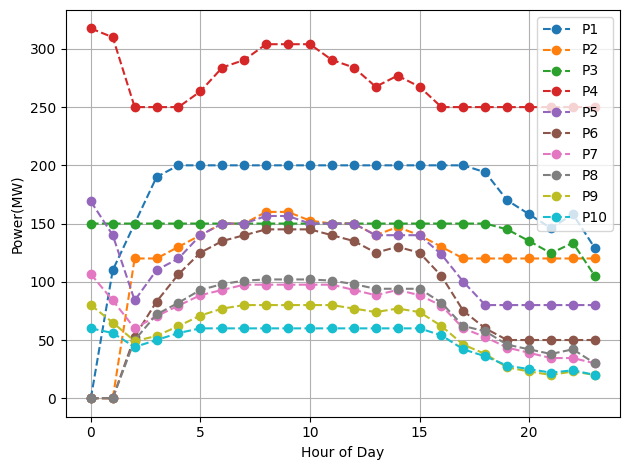

In [6]:
fig, axs = plt.subplots(1, 1)
for i in range(len(model.g)):
    axs.plot([value(model.Ptot[i+1,j]) for j in range(1,25)], "--o", label=f"P{i+1}")

axs.grid(True)
axs.legend()
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

# Cost-based UC with spinning reserve
In this problem, generators can offer part of their energy generation capacity as spinning reserve (SR). This means the generators can ramp up their production up to their spinning reserve allocation, in case of a sudden change in the grid energy balance such as an unexpected increase in energy demand, failure of some generators, or renewable under-performance. We need to add the following constraints to the problem [1]
$$
SR_{g,t} \le \bar{P}_{g,t} - Ptot_{g,t}
$$
$$
\sum_{g}^{} SR_{g,t} \ge \gamma L_{t}
$$
where $\gamma$ is the percentage of demand assigned as spinning reserve for resiliency, and $SR_{g,t}$ is the spinning reserve capacity for generator $g$ at time $t$. In this problem we assume $\gamma=0.4$. We also reduce the demand to 45% of its value in the previous section, to make the problem feasible [1].

In [7]:
for l in range(len(model.L)):
    model.L[l+1] = demands[l] * 0.45
    
#activate constraints for spinning reserve
model.c_spinning_reserve.activate()
model.c_spinning_reserve_load.activate()

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))
print("Total startup cost is $", sum(value(model.SUC[g,t]) for g in model.g for t in model.t))
print("Total fuel cost is $", sum(value(model.FC[g,t]) for g in model.g for t in model.t))
print("Total shutdown cost is $", sum(value(model.SDC[g,t]) for g in model.g for t in model.t))

In [ ]:
fig, axs = plt.subplots(2, 1)
for i in model.g:
    axs[0].plot([value(model.Ptot[i,j]) for j in range(1,25)], "--o", label=f"P{i}")
for i in model.g:
    axs[1].plot([value(model.SR[i,j]) for j in range(1,25)], "--o", label=f"SR{i}")

axs[0].grid(True), axs[1].grid(True)
axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=10, mode="expand", borderaxespad=0.)
axs[1].set_xlabel("Time of Day")
axs[1].set_ylabel("Spinning Reserve (MW)")
axs[0].set_ylabel("Power Schedule (MW)")

fig.tight_layout()
plt.show()

# Cost-based UC with generator contingency
In this case, we consider scenarios when some of the generators go offline. For a UC solution to be able to handle unexpected generator outages, we can add generator contincencies to the problem. This means that in case of a sudden generator failure, the spinning reserve capacity from other generators should be able to cover the lost energy from the failed generator. The following constraints can be added to the problem for contingency considerations [1]:
$$
\sum_{g}^{} Ptot_{g,t} \ge L_{t}
$$
$$
SR_{g,t} \le \bar{P}_{g,t} - Ptot_{g,t}
$$
$$
\sum_{g \neq \acute{g}}^{} SR_{g,t} \ge  Ptot_{\acute{g},t}   \ \ \ \  \forall \acute{g} \in \Omega_{c}
$$
where $\Omega_{c}$ is the set of generators for which we consider contingency power. In this example let's assume $\Omega_{c}$ includes all generators except for g4.

In [8]:
#deactivate constraints for spinning reserve, and activate the ones for contingency
model.c_spinning_reserve_load.deactivate()
model.c_contingency.activate()

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))
print("Total startup cost is $", sum(value(model.SUC[g,t]) for g in model.g for t in model.t))
print("Total fuel cost is $", sum(value(model.FC[g,t]) for g in model.g for t in model.t))
print("Total shutdown cost is $", sum(value(model.SDC[g,t]) for g in model.g for t in model.t))

Total operating cost is $ 210341.80513499997
Total startup cost is $ 199.0
Total fuel cost is $ 209759.30513499997
Total shutdown cost is $ 383.5


# Cost-based UC with demand response
So far we have only considered UC problems where demand is fixed and generation is optimized to meet the demand. In systems where the system operator can slightly change demand, the UC problem can be further optimized. This is called a demand response UC problem. In such cases, demand is no longer a fixed parameter, but a flexible parameter that needs to fall between a minimum and maximum acceptable values. Therefore, the following constraints need to be added to the problem [1]:
$$
\sum_{g}^{} Ptot_{g,t} \ge D_{t}
$$
$$
(1 - \varsigma_{min}) L_{t} \le D_{t} \le (1 + \varsigma_{max}) L_{t}
$$
$$
\sum_{t}^{} D_{t} = \sum_{t}^{} L_{t}
$$

In [9]:
#deactivate constraints for contingency and activate the ones for demand response
model.c_spinning_reserve.deactivate()
model.c_contingency.deactivate()
model.c_demand_generation.deactivate()

model.c_demand_generation_DR.activate()
model.c_demand_response_UB.activate()
model.c_demand_response_LB.activate()
model.c_demand_response_Load.activate()

results = opt.solve(model)

print("Total operating cost is $", value(model.objective))
print("Total startup cost is $", sum(value(model.SUC[g,t]) for g in model.g for t in model.t))
print("Total fuel cost is $", sum(value(model.FC[g,t]) for g in model.g for t in model.t))
print("Total shutdown cost is $", sum(value(model.SDC[g,t]) for g in model.g for t in model.t))

Total operating cost is $ 209640.1432995
Total startup cost is $ 142.0
Total fuel cost is $ 209228.6432995
Total shutdown cost is $ 269.5


By changing the values of $\varsigma_{min}$ and $\varsigma_{max}$, we can explore the effect of these parameters on the UC problem.

In [10]:
cminmax_sensitivity_df = pd.DataFrame(columns=["cminmax", "DR"])
cminmaxs = [0,0.03,0.06,0.09,0.12,0.15,0.18]
for i, cminmax in enumerate(cminmaxs):
    model.cmin = cminmax
    model.cmax = cminmax
    results = opt.solve(model)
    cminmax_sensitivity_df.loc[i, "cminmax"] = cminmax
    cminmax_sensitivity_df.loc[i, "DR"] = [value(model.D[t]) for t in model.t]

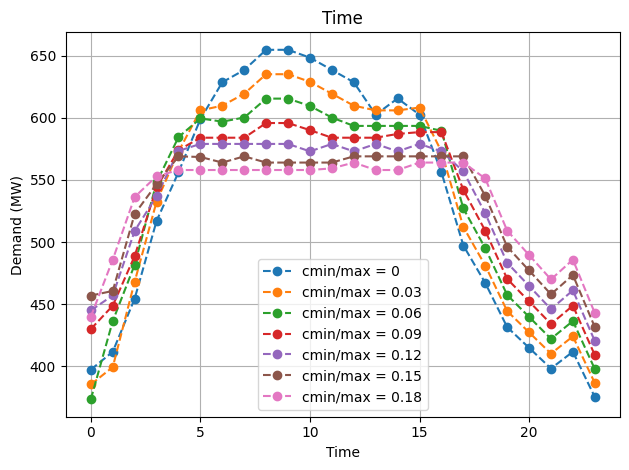

In [11]:
fig, axs = plt.subplots(1, 1)
for i in range(len(cminmax_sensitivity_df)):
    cminmax = cminmax_sensitivity_df.loc[i,"cminmax"]
    axs.plot(cminmax_sensitivity_df.loc[i,"DR"], "--o", label=f"cmin/max = {cminmax}")

axs.grid(True)
axs.set_xlabel("Time")
axs.set_ylabel("Demand (MW)")
axs.set_title("Time")
axs.legend()

fig.tight_layout()
plt.show()

# Price-based UC
In price-based unit commitment, the goal is to maximize revenue. In this case, we take into account the price of energy as well as the cost of generation which enatils fuel cost, startup cost, and shutdown cost. The price based Uc formulation is very similar to cost-based UC, with 2 distinctions [1]:<br>
**Objective Function:**
$$
\underset{p,u,y,z} {max} \ \ \ \ \sum_{g,t}^{} \left\{ \lambda_{t} Ptot_{g,t} - \left[ FC_{g,t} + Su_{g} y_{g,t} + Sd_{g} z_{g,t} \right] \right\}
$$
**Generation-demand constraint:**
$$
\sum_{g}^{} Ptot_{g,t} \le L_{t}
$$

In [12]:
for l in range(len(model.L)):
    model.L[l+1] = demands[l]
    
#deactivate constraints for demand response, and activate the ones for price-based UC
model.c_demand_generation_DR.deactivate()
model.c_demand_response_UB.deactivate()
model.c_demand_response_LB.deactivate()
model.c_demand_response_Load.deactivate()
model.objective.deactivate()

model.objective_price.activate()
model.c_demand_generation_price.activate()

results = opt.solve(model)

print("Total revenue is $", value(model.objective_price))
print("Total startup cost is $", sum(value(model.SUC[g,t]) for g in model.g for t in model.t))
print("Total fuel cost is $", sum(value(model.FC[g,t]) for g in model.g for t in model.t))
print("Total shutdown cost is $", sum(value(model.SDC[g,t]) for g in model.g for t in model.t))

Total revenue is $ 60643.7720249999
Total startup cost is $ 440.5
Total fuel cost is $ 378434.26797499997
Total shutdown cost is $ 163.5


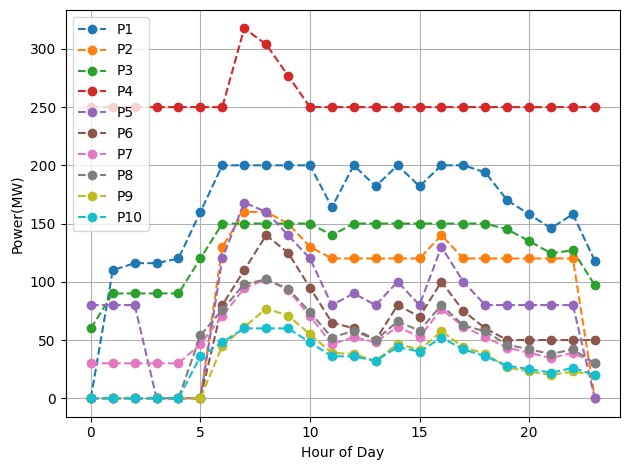

In [13]:
fig, axs = plt.subplots(1, 1)

for i in range(len(model.g)):
    axs.plot([value(model.Ptot[i+1,j]) for j in range(1,25)], "--o", label=f"P{i+1}")

axs.grid(True)
axs.legend()
axs.set_xlabel("Hour of Day")
axs.set_ylabel("Power(MW)")

fig.tight_layout()
plt.show()

# References
1. Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.
2. Ademovic A, Bisanovic S, Hajro M. A genetic algorithm solution to the unit commitment problem based on real-coded chromosomes and fuzzy optimization. InMelecon 2010-2010 15th IEEE Mediterranean Electrotechnical Conference 2010 Apr 26 (pp. 1476-1481). IEEE.
3. Arroyo JM, Conejo AJ. Optimal response of a thermal unit to an electricity spot market. IEEE Transactions on power systems. 2000 Aug;15(3):1098-104.